In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Binary_Dataset"

/content/drive/MyDrive/Binary_Dataset


In [5]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00


In [17]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.keras as efn
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [18]:
base_dir = '/content/drive/MyDrive/Binary_Dataset'
train_dir = os.path.join(base_dir, '1_Training')
validation_dir = os.path.join(base_dir, '2_Validation')

In [19]:
# Directory with our training cat pictures
train_micro_dir = os.path.join(train_dir, '2_Microplastics')

# Directory with our training dog pictures
train_clean_dir = os.path.join(train_dir, '1_Clean_Water')

# Directory with our validation cat pictures
validation_micro_dir = os.path.join(validation_dir, '2_Microplastics')

# Directory with our validation dog pictures
validation_clean_dir = os.path.join(validation_dir, '1_Clean_Water')

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and rescaling for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for the validation set
validation_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)


# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(224, 224)
)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(224, 224)
)


Found 1167 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


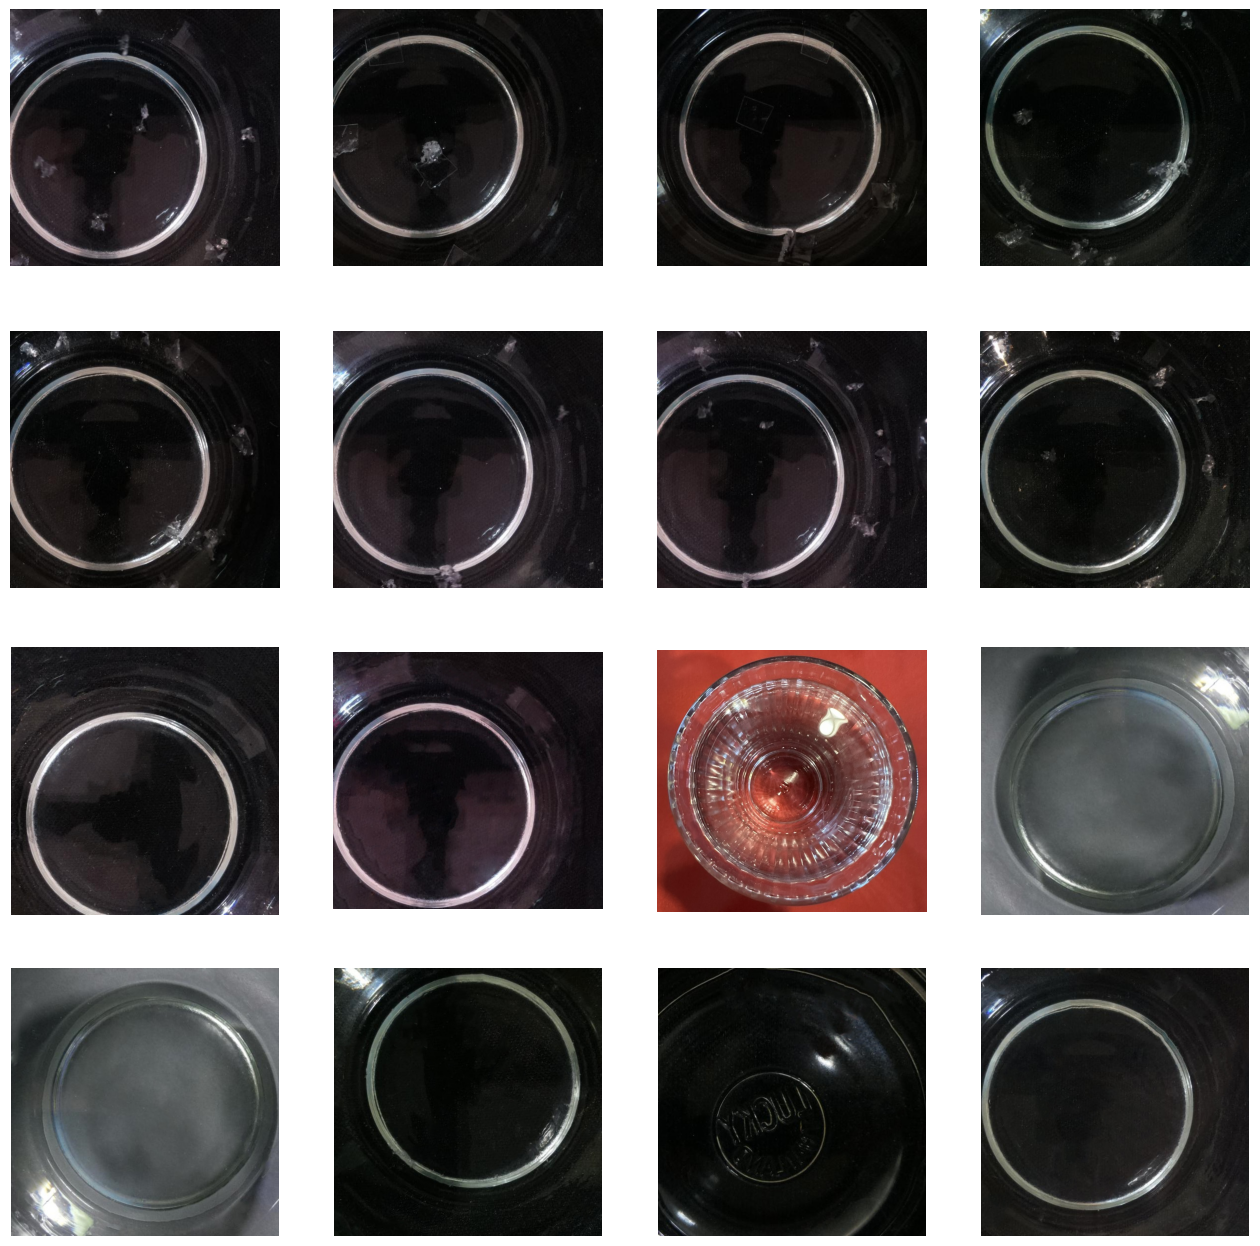

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Directories containing the images
train_micro_fnames = os.listdir(train_micro_dir)
train_clean_fnames = os.listdir(train_clean_dir)
random_micro_pix = random.sample(train_micro_fnames, 8)
random_clean_pix = random.sample(train_clean_fnames, 8)

# Combine the selected images
selected_images = [os.path.join(train_micro_dir, fname) for fname in random_micro_pix] + \
                  [os.path.join(train_clean_dir, fname) for fname in random_clean_pix]

# Set up matplotlib figure, and size it to fit 4x4 pictures
nrows = 4
ncols = 4
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# Plot each image
for i, img_path in enumerate(selected_images):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')  # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


In [22]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

16804768/16804768 [==============================] - 0s 0us/step


In [23]:
for layer in base_model.layers:
    layer.trainable = False

In [58]:
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Define the model with batch normalization and L1 and L2 regularization in dense layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001))(x)  # Add L2 regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs=base_model.input, outputs=predictions)


In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



In [60]:
from tensorflow.keras.optimizers import RMSprop

# Assuming 'model_final' is already defined as per your previous code
optimizer = RMSprop(learning_rate=0.0001,   rho=0.9)
model_final.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [61]:
model_final.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']       

In [62]:
eff_history = model_final.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks=[early_stop])


Epoch 1/10
59/59 [==============================] - 44s 422ms/step - loss: 0.5542 - accuracy: 0.8972 - val_loss: 0.3343 - val_accuracy: 0.9567
Epoch 2/10
59/59 [==============================] - 24s 399ms/step - loss: 0.3928 - accuracy: 0.9349 - val_loss: 0.2879 - val_accuracy: 0.9760
Epoch 3/10
59/59 [==============================] - 23s 378ms/step - loss: 0.3602 - accuracy: 0.9443 - val_loss: 0.3208 - val_accuracy: 0.9615
Epoch 4/10
59/59 [==============================] - 24s 400ms/step - loss: 0.3143 - accuracy: 0.9563 - val_loss: 0.2739 - val_accuracy: 0.9856
Epoch 5/10
59/59 [==============================] - 22s 367ms/step - loss: 0.3120 - accuracy: 0.9632 - val_loss: 0.2270 - val_accuracy: 0.9904
Epoch 6/10
59/59 [==============================] - 23s 396ms/step - loss: 0.2960 - accuracy: 0.9726 - val_loss: 0.2151 - val_accuracy: 0.9952
Epoch 7/10
59/59 [==============================] - 23s 389ms/step - loss: 0.3294 - accuracy: 0.9546 - val_loss: 0.2449 - val_accuracy: 0.9808

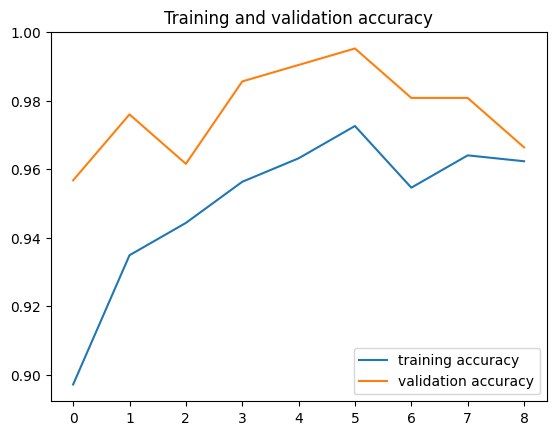

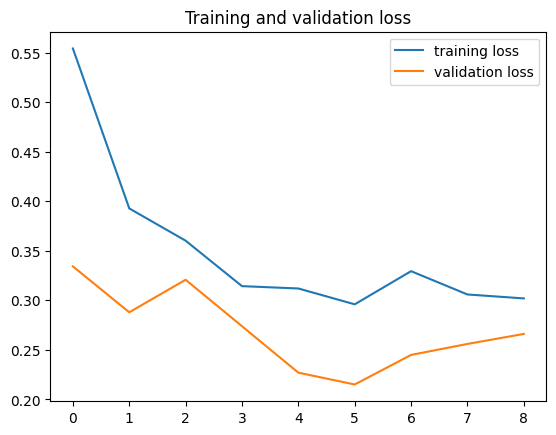

In [63]:
#@title Graphing accuracy and loss


# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = eff_history.history['accuracy']
val_acc = eff_history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = eff_history.history['loss']
val_loss = eff_history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_data_dir = os.path.join(base_dir, '3_Testing')


# Create a data generator for test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and iterate over test data in batches
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Resize images to match the input size of your model
    batch_size=20,
    class_mode='binary',  # Set the class mode to 'binary' for binary classification
    shuffle=False  # Ensure that the generator returns data in order
)


Found 200 images belonging to 2 classes.


In [65]:
# Make predictions on the test data
predictions = model_final.predict(test_generator)

# Assuming test_generator.classes gives


10/10 [==============================] - 3s 146ms/step


In [66]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test data
predictions = model_final.predict(test_generator)

# Convert probabilities to binary predictions
predicted_classes = (predictions > 0.5).astype('int32').flatten()

# Get true class labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluate predictions
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy on test data: {accuracy}")

# Detailed classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Count correct predictions for each class
correct_predictions_microplastics = np.sum((true_classes == 0) & (predicted_classes == 0))
correct_predictions_clean = np.sum((true_classes == 1) & (predicted_classes == 1))

print(f"Correct predictions for 'microplastics': {correct_predictions_microplastics}")
print(f"Correct predictions for 'clean': {correct_predictions_clean}")


10/10 [==============================] - 1s 140ms/step
Accuracy on test data: 0.985
Classification Report:
                 precision    recall  f1-score   support

  1_Clean_Water       0.98      0.99      0.99       100
2_Microplastics       0.99      0.98      0.98       100

       accuracy                           0.98       200
      macro avg       0.99      0.98      0.98       200
   weighted avg       0.99      0.98      0.98       200

Confusion Matrix:
[[99  1]
 [ 2 98]]
Correct predictions for 'microplastics': 99
Correct predictions for 'clean': 98


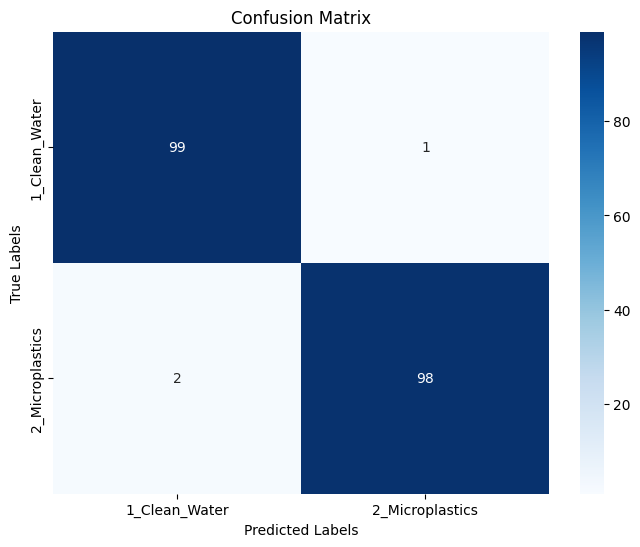

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [69]:
model_final.save('/content/drive/MyDrive/New folder/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('/content/drive/MyDrive/New folder/model.h5')
# Function to preprocess and predict a single image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale pixel values to [0, 1]

    prediction = model.predict(img_array)
    if prediction > 0.5:
        predicted_class = "Microplastics"
    else:
        predicted_class = "Clean Water"

    # Display the image with the prediction
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')  # Hide axes
    plt.show()

    return predicted_class





1/1 [==============================] - 4s 4s/step


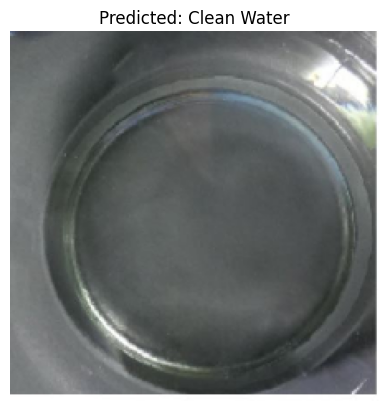

The predicted class for the image is: Clean Water


In [71]:
# Example usage
img_path = '/content/drive/MyDrive/New folder/2.JPG'
result = predict_image(img_path)
print(f'The predicted class for the image is: {result}')

1/1 [==============================] - 0s 96ms/step


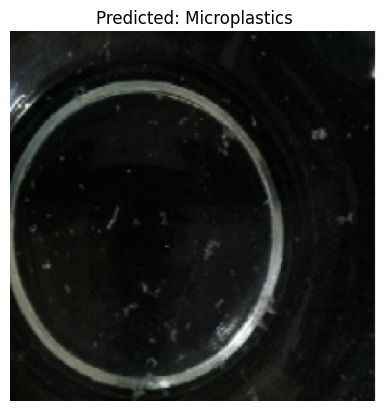

The predicted class for the image is: Microplastics


In [72]:

# Example usage
img_path = '/content/drive/MyDrive/New folder/3.JPG'
result = predict_image(img_path)
print(f'The predicted class for the image is: {result}')

1/1 [==============================] - 0s 88ms/step


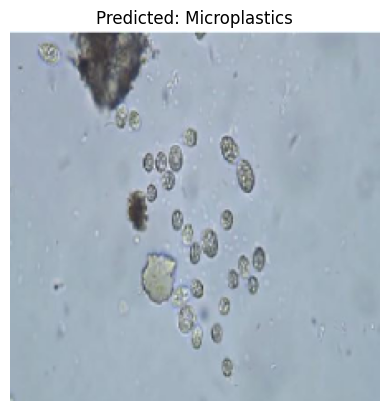

The predicted class for the image is: Microplastics


In [73]:

# Example usage
img_path = '/content/drive/MyDrive/New folder/4.JPG'
result = predict_image(img_path)
print(f'The predicted class for the image is: {result}')

1/1 [==============================] - 0s 42ms/step


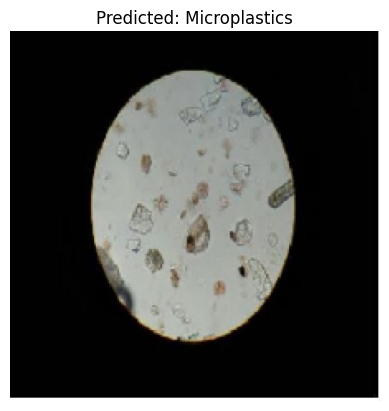

The predicted class for the image is: Microplastics


In [74]:

# Example usage
img_path = '/content/drive/MyDrive/New folder/5.JPG'
result = predict_image(img_path)
print(f'The predicted class for the image is: {result}')

1/1 [==============================] - 0s 44ms/step


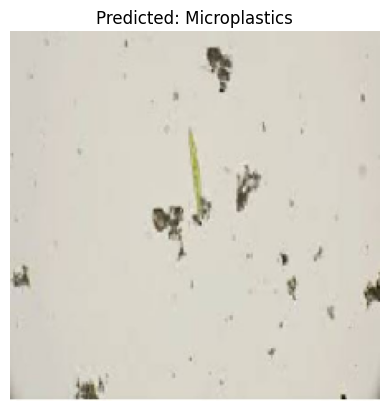

The predicted class for the image is: Microplastics


In [75]:

# Example usage
img_path = '/content/drive/MyDrive/New folder/6.JPG'
result = predict_image(img_path)
print(f'The predicted class for the image is: {result}')

1/1 [==============================] - 0s 44ms/step


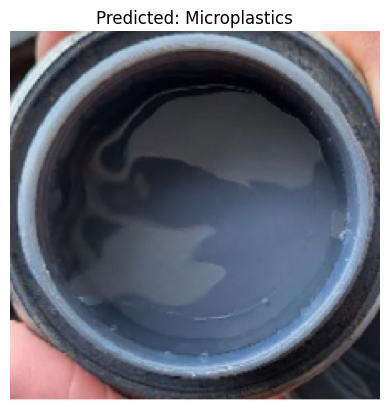

The predicted class for the image is: Microplastics


In [76]:
# Example usage
img_path = '/content/drive/MyDrive/New folder/7.JPG'
result = predict_image(img_path)
print(f'The predicted class for the image is: {result}')

1/1 [==============================] - 0s 65ms/step


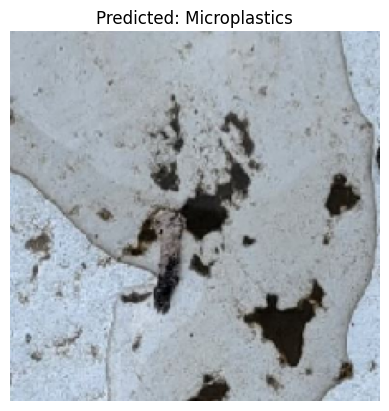

The predicted class for the image is: Microplastics


In [77]:
# Example usage
img_path = '/content/drive/MyDrive/New folder/8.JPG'
result = predict_image(img_path)
print(f'The predicted class for the image is: {result}')

1/1 [==============================] - 0s 46ms/step


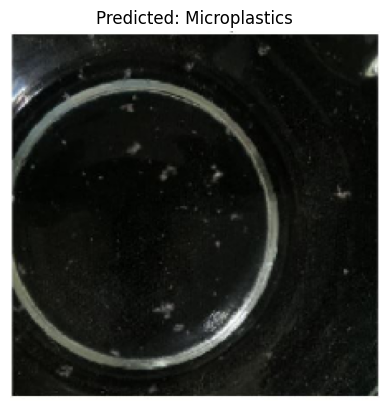

The predicted class for the image is: Microplastics


In [78]:
# Example usage
img_path = '/content/drive/MyDrive/New folder/Capture.JPG'
result = predict_image(img_path)
print(f'The predicted class for the image is: {result}')